# Coding vs non-coding
K-mer count features extracted from GenCode pc and nc RNA. 
Use GenCode 34. 
Use one RNA per gene; the one transcript with median length (use floor where count is even).

Same process for protein coding and non-coding.
* Start with GenCode 34 fasta file.
* Run gencode_preprocess.py to make all caps and remove long seqs, short seqs, seqs with N. For each gene with multiple transcripts, choose the one transcript with median length. Among the remaining, remove any sequences that are duplicates of previous ones (We find up to 7 exact duplicate sequences per sequence identifier).
* Run spot_dupes to make sure the dupes are gone.
* Run fasta_to_feature.py to generate CSV file of K-mer counts.
* Run trivial_kmer_counter.py on subset of sequences to verify the K-mer counting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Non-coding Instances

In [2]:
ncfile='ncRNA.2mer.features.csv'
nc_features = pd.read_csv(ncfile,header=0)
nc_features.head()
# Our non-coding sequence numbers start at 1. 

,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,1,535,39,21,38,30,31,48,11,44,31,30,26,28,27,36,40,54
1,2,590,37,21,47,27,43,55,9,51,35,42,55,26,18,40,46,37
2,3,629,61,30,53,41,48,41,5,45,48,30,31,32,28,38,51,46
3,4,1319,109,68,127,77,110,75,16,82,106,79,100,58,57,61,100,93
4,5,323,16,21,26,12,28,23,4,21,24,23,31,19,7,9,37,21


In [3]:
nc_features.shape

(17711, 18)

In [4]:
# Longest sequence in each class.
# Before filtering, there was a 200Kb lncRNA!
# Max lengths were 205K, 92K, 49K, 37K, 23K, ...
nc_features['seqlen'].min(), nc_features['seqlen'].max()

(200, 23112)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe333f623a0>]],
      dtype=object)

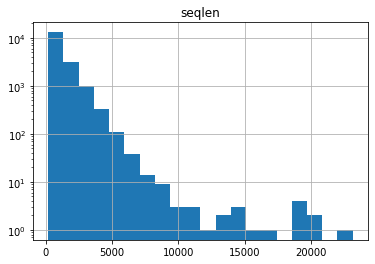

In [5]:
# In preprocessing, we removed ~180 seqs < 200bp and 3 seqs > 30Kbp.
# There are still ~20 outliers having len > 12Kbp.
nc_features.hist(column='seqlen',bins=20, log=True)

## Import Protein-coding instances

In [6]:
pcfile='pcRNA.2mer.features.csv'
pc_features = pd.read_csv(pcfile,header=0)
pc_features.head()
# Our protein-coding seqnums start at 50,000 (arbitrary but bove any non-coding).
# Before removing duplicates, we had 365 transcripts of length 582 from different genes,
# and two sequences that occurred 7 times each with different gene IDs & transcript IDs.

,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,1,1054,62,56,53,91,78,57,13,91,55,38,40,65,67,89,92,106
1,2,995,41,54,54,66,79,68,8,99,48,42,47,63,46,90,92,97
2,3,2191,75,104,173,42,154,305,136,162,143,236,259,68,22,111,138,62
3,4,2757,123,131,251,77,201,234,124,219,219,254,273,125,40,159,222,104
4,5,1950,42,113,110,51,123,237,128,154,110,184,194,118,41,107,174,63


In [7]:
pc_features.shape

(20152, 18)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe33806a070>]],
      dtype=object)

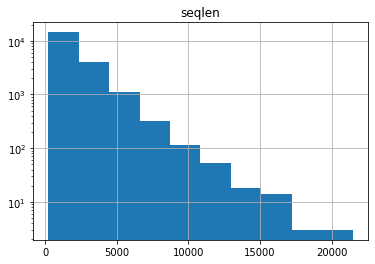

In [8]:
# Length distribution show exponential decay till about 15Kb.
# We won't worry about the few outliers. The longest is 21470.
pc_features.hist(column='seqlen',bins=10, log=True)

## Generate train set, test set
Introduce the labels 0=non-coding, 1=protein-coding.
We are worried that the longest sequences are a special case.
Use stratified split to ensure an even split of train/test by sequence length.

In [9]:
# Manufacture labels for the two datasets
nc_labels_temp=[0]*nc_features.shape[0]
pc_labels_temp=[1]*pc_features.shape[0]
nc_labels=pd.core.frame.DataFrame(nc_labels_temp,columns=['label'])
pc_labels=pd.core.frame.DataFrame(pc_labels_temp,columns=['label'])
nc_all=pd.concat([nc_labels,nc_features],axis='columns')
pc_all=pd.concat([pc_labels,pc_features],axis='columns')
nc_all.shape, pc_all.shape

((17711, 19), (20152, 19))

In [10]:
# And combine non-coding + protein-coding into one data structure.
all_instances=pd.concat([nc_all,pc_all])
all_instances.shape

(37863, 19)

In [11]:
# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
bin_labels= sizebin(all_instances)
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
# split(x,y) expects that y is the labels. 
# Trick: Instead of y, give it it the bin labels that we generated.
for train_index,test_index in splitter.split(all_instances,bin_labels):
    train_set = all_instances.iloc[train_index]
    test_set = all_instances.iloc[test_index]
train_set.shape

(30290, 19)

In [12]:
# Was the stratified split successful?
# Test whether test set bin sizes are similar to entire set bin sizes.

# First, list bin sizes for entire set.
# Second, list bin sizes for the train set.
all_labels= sizebin(all_instances)
train_labels= sizebin(train_set)
tot_all=len(all_labels)
tot_train=len(train_labels)
for i in range(6):
    # Using value_counts returns unique count, and anyway hits a recursion limit here.
    truth=all_labels.apply(lambda x: True if x==i else False)
    cnt1=len(truth[truth==True].index)
    truth=train_labels.apply(lambda x: True if x==i else False)
    cnt2=len(truth[truth==True].index)
    print("%3d %7d %10f vs %7d %10f"%(i,cnt1,cnt1/tot_all,cnt2,cnt2/tot_train))
#cat all_num   all_pct     train_num   train_pct   

  0   18708   0.494097 vs   14966   0.494090
  1    9596   0.253440 vs    7677   0.253450
  2    7066   0.186620 vs    5653   0.186629
  3    2188   0.057787 vs    1750   0.057775
  4     283   0.007474 vs     226   0.007461
  5      22   0.000581 vs      18   0.000594


In [13]:
# Looks good!
train_set

,label,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
1280,0,1281,348,27,16,30,25,26,19,3,16,27,11,25,21,18,18,26,39
9088,0,9089,534,60,24,44,25,43,41,8,40,29,36,47,24,22,30,37,23
6069,1,6070,592,44,34,63,25,50,39,19,27,55,32,65,32,16,30,38,22
18549,1,18550,945,72,46,70,48,52,43,65,38,85,61,83,66,28,48,76,63
15027,1,15028,4382,177,222,310,108,298,515,368,278,270,483,467,177,73,239,251,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,0,3387,578,74,24,35,59,35,15,3,22,31,18,20,41,52,18,53,77
6495,0,6496,562,44,23,52,33,44,36,4,39,44,30,40,24,19,34,42,53
6409,1,6410,740,52,32,80,31,50,43,23,48,61,49,99,32,32,40,39,28
7640,1,7641,3156,206,187,230,165,259,280,78,230,223,182,230,144,100,198,241,202


In [14]:
# Move the seqnum and seqlen columns to a separate matrix.
# Move the labels column to a separate matrix.
X_train_ids=train_set[['seqnum','seqlen']].copy()
y_train=    train_set[['label']].copy()
X_train=    train_set.drop(columns=['label','seqnum','seqlen'])
train_set=None
X_test_ids= test_set[['seqnum','seqlen']].copy()
y_test=     test_set[['label']].copy()
X_test=     test_set.drop(columns=['label','seqnum','seqlen'])
test_set=None

In [15]:
X_train

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
1280,27,16,30,25,26,19,3,16,27,11,25,21,18,18,26,39
9088,60,24,44,25,43,41,8,40,29,36,47,24,22,30,37,23
6069,44,34,63,25,50,39,19,27,55,32,65,32,16,30,38,22
18549,72,46,70,48,52,43,65,38,85,61,83,66,28,48,76,63
15027,177,222,310,108,298,515,368,278,270,483,467,177,73,239,251,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,74,24,35,59,35,15,3,22,31,18,20,41,52,18,53,77
6495,44,23,52,33,44,36,4,39,44,30,40,24,19,34,42,53
6409,52,32,80,31,50,43,23,48,61,49,99,32,32,40,39,28
7640,206,187,230,165,259,280,78,230,223,182,230,144,100,198,241,202


In [16]:
X_train.shape, X_test.shape

((30290, 16), (7573, 16))

In [18]:
y_train.shape, y_test.shape

((30290, 1), (7573, 1))